### Import Modules and Python Functions

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
with open('../python/variables.yaml') as info:
    VARS = yaml.load(info, Loader=yaml.FullLoader)

# visualization modules
import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from random import randint
from pylab import rcParams

### Import Variables

In [2]:
# Events
events_csv = VARS['EVENTS_CSV']
events_cols_all = VARS['EVENTS_COLS_ALL']
events_cols_select = VARS['EVENTS_COLS_SELECT']

# Mentions
mentions_csv = VARS['MENTIONS_CSV']
mentions_cols_all = VARS['MENTIONS_COLS_ALL']
mentions_cols_select = VARS['MENTIONS_COLS_SELECT']

# Pilot
cameo_verbs = VARS['CAMEO_VERBS']
cameo_quadclass = VARS['CAMEO_QUADCLASS']
select_countries_60 = VARS['PILOT_COUNTRIES_IOS2']

### Define Reusable Python Functions

In [3]:
def get_var_percentages(df: pd, target_col: str, sort=False) -> pd:
    """Get Percentage of Column Values in Target Column of Cleaned GDELT Data
    :param df: dataframe of cleaned data
    :param target_col: column name of variable of interest
    :rtype: dataframe
    :return: dataframe
    """

    # Create a sub-dataframe to group GLOBALEVENTID by Target Column
    grouped_df = df[['GLOBALEVENTID', target_col]].groupby(target_col).count()
    
    # Get variable percentage                                                                
    grouped_df['%'] = (grouped_df['GLOBALEVENTID'] / grouped_df['GLOBALEVENTID'].sum()) * 100
    
    if sort==True:
        grouped_df = grouped_df.sort_values(by='%', ascending=False).reset_index()
    
    return grouped_df

In [4]:
def plot_piechart(df: pd, target_cols: str, pie_title: str, save_png: str) -> pd:
    """ Create colorful pie chart showing percent of events by variable label
    :param df: dataframe created via the get_var_percentages() function
    :param target_cols: target column in the get_var_percentages() function
    :param pie_title: target column string for pie chart title
    :param save_png: string based on the target column for storing png
    """
    # Create color list for pie chart visualization
    labels = df[target_cols]
    colors = []
    for i in range(len(labels)):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    
    if len(np.unique(labels)) > 10:
        rcParams['figure.figsize'] = 30,30
    else:
        rcParams['figure.figsize'] = 8,8

    # Plot
    plt.pie(df['%'], colors=colors, labels=labels, autopct='%1.1f%%')
    plt.title('Percentage of Events by '+ pie_title)
    plt.savefig('../images/' + save_png + '.png', dpi=300)
    plt.show()

### Import Data

In [5]:
# Store dataframe globally
%store -r cleaned_merged_df
print(cleaned_merged_df.shape)
cleaned_merged_df.head()

(437776, 16)


,GLOBALEVENTID,EventTimeDate,MentionTimeDate,DaysBetween,Confidence,MentionDocTone,ActionGeo_CountryCode,ActionGeo_FullName,EventCode,EventRootCodeString,QuadClass,QuadClassString,GoldsteinScale,ActionGeo_Lat,ActionGeo_Long,SOURCEURL
0,968305988,2021-02-06 11:45:00,2021-02-06 11:45:00,0,100,-1.383043,IS,Iceland,75.0,PROVIDE AID,2,Material Cooperation,7.0,29.766700,34.98330,https://blogs.timesofisrael.com/israels-interi...
1,970822400,2021-02-21 19:30:00,2021-02-21 19:30:00,0,60,-2.877698,AG,Antigua and Barbuda,834.0,YIELD,2,Material Cooperation,5.0,36.763100,3.05056,https://www.aa.com.tr/en/middle-east/algeria-d...
2,970752273,2021-02-21 05:15:00,2021-02-21 05:15:00,0,20,4.621849,CH,Switzerland,86.0,YIELD,2,Material Cooperation,9.0,35.000000,105.00000,http://www.china.org.cn/world/2021-02/21/conte...
3,971681977,2021-02-26 06:45:00,2021-02-26 06:45:00,0,50,-0.581395,SN,Senegal,44.0,CONSULT,1,Verbal Cooperation,2.5,1.366667,103.80000,https://www.malaysiakini.com/news/564438
4,968704114,2021-02-09 06:45:00,2021-02-09 06:45:00,0,20,0.665779,RS,Serbia,152.0,EXHIBIT MILITARY POSTURE,4,Material Conflict,-7.2,60.000000,100.00000,https://www.ukrinform.ua/rubric-society/318644...


## Assess Metrics

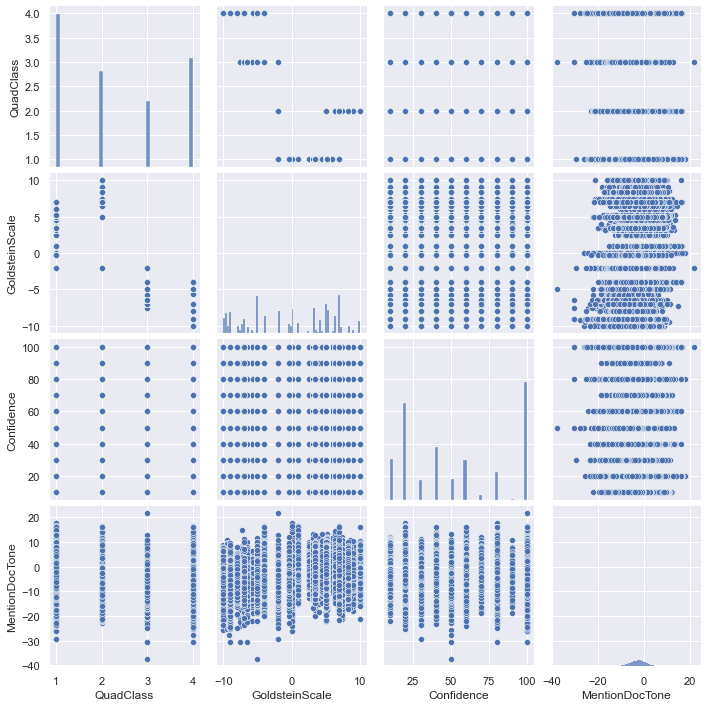

In [6]:
sns.pairplot(cleaned_merged_df[['QuadClass','GoldsteinScale','Confidence','MentionDocTone']])

Observations: While this needs to be assessed with more data, there doesn't appear to be any sort of *visually detectable* relationship between the general tone (MentionDocTone) of a source, the validity score (Confidence) of a source to the resulting behavioral (Quad) class and calculated Goldstein score of an event; this was slightly unexpected, especially in regards to the general tone (MentionDocTone) of a source. However, there is a *visually detectable* relationship between between the behavioral (Quad) class and Goldstein score of an event, which is to be expected. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 1: Can the country's full name column within the GDELT data be used in the drop-down list?

In [7]:
# Create a sub-dataframe to show ActionGeo_FullName and ActionGeo_CountryCode
countries = cleaned_merged_df[['ActionGeo_CountryCode', 'ActionGeo_FullName']].sort_values(by='ActionGeo_CountryCode')
countries = countries.drop_duplicates()
print(len(countries))
countries

244


,ActionGeo_CountryCode,ActionGeo_FullName
13655,AA,NaN
3578,AC,NaN
333743,AE,United Arab Emirates
139211,AF,Afghanistan
223651,AG,Antigua and Barbuda
...,...,...
384818,WZ,NaN
288767,YI,NaN
73612,YM,NaN
122649,ZA,South Africa


Observations: Since there are not 289 countries, it's best to assess the number of Countries within this dataset is to look at country codes, then count the number of full name options per country code

In [8]:
# Create a derivative dataframe to show count ActionGeo_CountryCode and count ActionGeo_FullName per code
countries_codes = countries.groupby('ActionGeo_CountryCode').count().sort_values(by='ActionGeo_CountryCode')
countries_codes = countries_codes.drop_duplicates()
print(len(countries_codes))
countries_codes

2


,ActionGeo_FullName
ActionGeo_CountryCode,
AA,0
AE,1


#### Conclusions: The full name reference of each country is highly variable (ie. within this subset of data, US has 104 full name variations). Thus, for the drop-down selection portion of the dashboard, the country IOS2 code will be used.

### Question 2: What is the total count of events by the most granular-level of time? By country?

/Users/emily-work/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


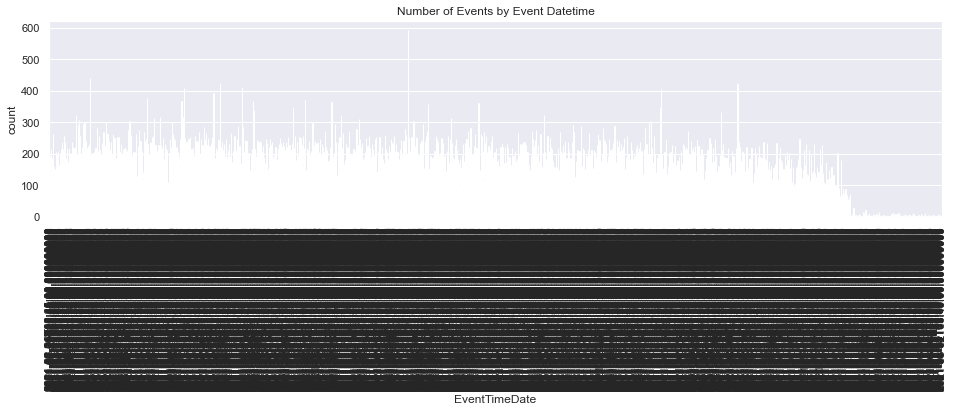

In [9]:
# Create a bar graph to show distribution of incidences of maternal death by region
fig, ax = plt.subplots(figsize=(16, 4))
plt.xticks(rotation='vertical')
plt.grid(True)
fig.subplots_adjust(bottom=0.2)
sns.countplot(cleaned_merged_df['EventTimeDate'])
plt.title('Number of Events by Event Datetime')
plt.show()

Observations: This needs to be assessed with more data. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

#### By Country

/Users/emily-work/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


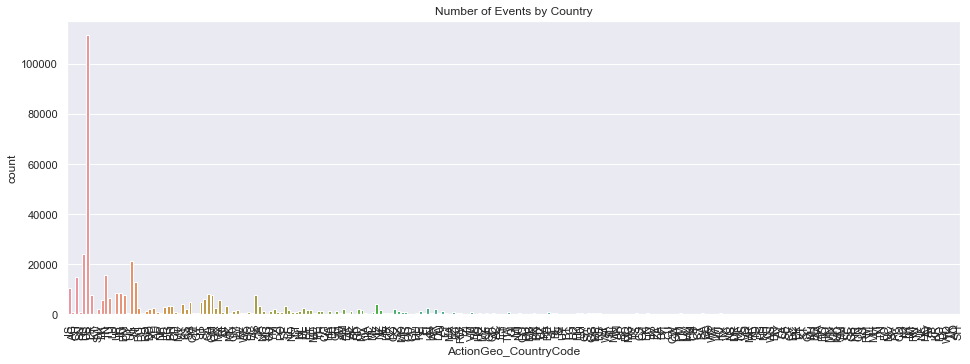

In [10]:
# Create a bar graph to show distribution of incidences of maternal death by region
fig, ax = plt.subplots(figsize=(16, 6))
plt.xticks(rotation='vertical')
plt.grid(True)
fig.subplots_adjust(bottom=0.2)
sns.countplot(cleaned_merged_df['ActionGeo_CountryCode'])
plt.title('Number of Events by Country')
plt.show()

Observations: While this needs to be assessed with more data, it appears that the US has substantially more records when compared to all other countries within this dataset. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 2: What is the Percentage of Events per QuadClass? What is the MODE Confidence and Tone per QuadClass?

#### Percentage of Events by QuadClass

In [11]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass
quadclass = get_var_percentages(cleaned_merged_df, 'QuadClassString', sort=True)
quadclass

,QuadClassString,GLOBALEVENTID,%
0,Verbal Cooperation,158263,36.151594
1,Material Conflict,112210,25.631830
2,Material Cooperation,99400,22.705676
3,Verbal Conflict,67903,15.510901


#### Visualize

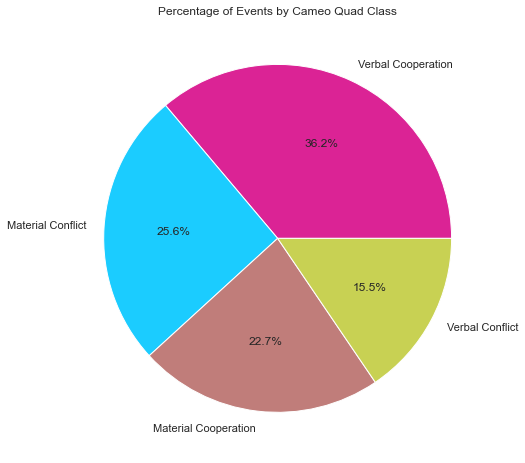

In [12]:
plot_piechart(quadclass, 'QuadClassString', 'Cameo Quad Class', 'cameo_quadclass_percentages')

Observations: While this needs to be assessed with more data, it does appear that QuadClass 1, meaning Verbal Cooperation, is the most prevelant, followed by QuadClass 4, Material Cooperation. However, is based on the previous section, it would be worthwhile to remove US-associated events and re-assess. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

In [13]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass without US 
non_us_df = cleaned_merged_df.loc[ cleaned_merged_df['ActionGeo_CountryCode'] != 'US' ]
non_us_quadclass = get_var_percentages(non_us_df, 'QuadClass')
non_us_quadclass

,GLOBALEVENTID,%
QuadClass,,
1,113034,34.649517
2,75024,22.997906
3,49525,15.181426
4,88638,27.171151


Observations: The propotions seemed to have remained roughly the same with a slight increase in QuadClass 1 and 4 and slight decreases in QuadClass 2 and 3. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

#### By Country

#### Mode of Confidence and MentionDocTone Values by QuadClass

In [14]:
# Create a sub-dataframe to group GLOBALEVENTID by QuadClass
quadclass_modes = cleaned_merged_df[['QuadClass','Confidence','MentionDocTone']
                                   ].groupby('QuadClass').agg(lambda x: pd.Series.mode(x)[0])
quadclass_modes

,Confidence,MentionDocTone
QuadClass,,
1,100,0.0
2,100,0.0
3,100,0.0
4,100,0.0


Observations: The propotions seemed to have remained roughly the same with a slight increase in QuadClass 1 and 4 and slight decreases in QuadClass 2 and 3. This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 2: What is the Percentage of Events per EventRootCode? What is the MODE Confidence and Tone per EventRootCode?

In [15]:
# Create a sub-dataframe to group GLOBALEVENTID by EventRootCode
cameoaction = get_var_percentages(cleaned_merged_df, 'EventRootCodeString', sort=True)
cameoaction

,EventRootCodeString,GLOBALEVENTID,%
0,YIELD,62363,14.245413
1,MAKE PUBLIC STATEMENT,47175,10.776059
2,APPEAL,42865,9.791537
3,EXPRESS INTENT TO COOPERATE,37881,8.653055
4,ASSAULT,28282,6.460382
5,COERCE,25973,5.932943
6,ENGAGE IN MATERIAL COOPERATION,25387,5.799084
7,FIGHT,24249,5.539134
8,REJECT,23781,5.432230
9,REDUCE RELATIONS,22692,5.183473


#### Visualize

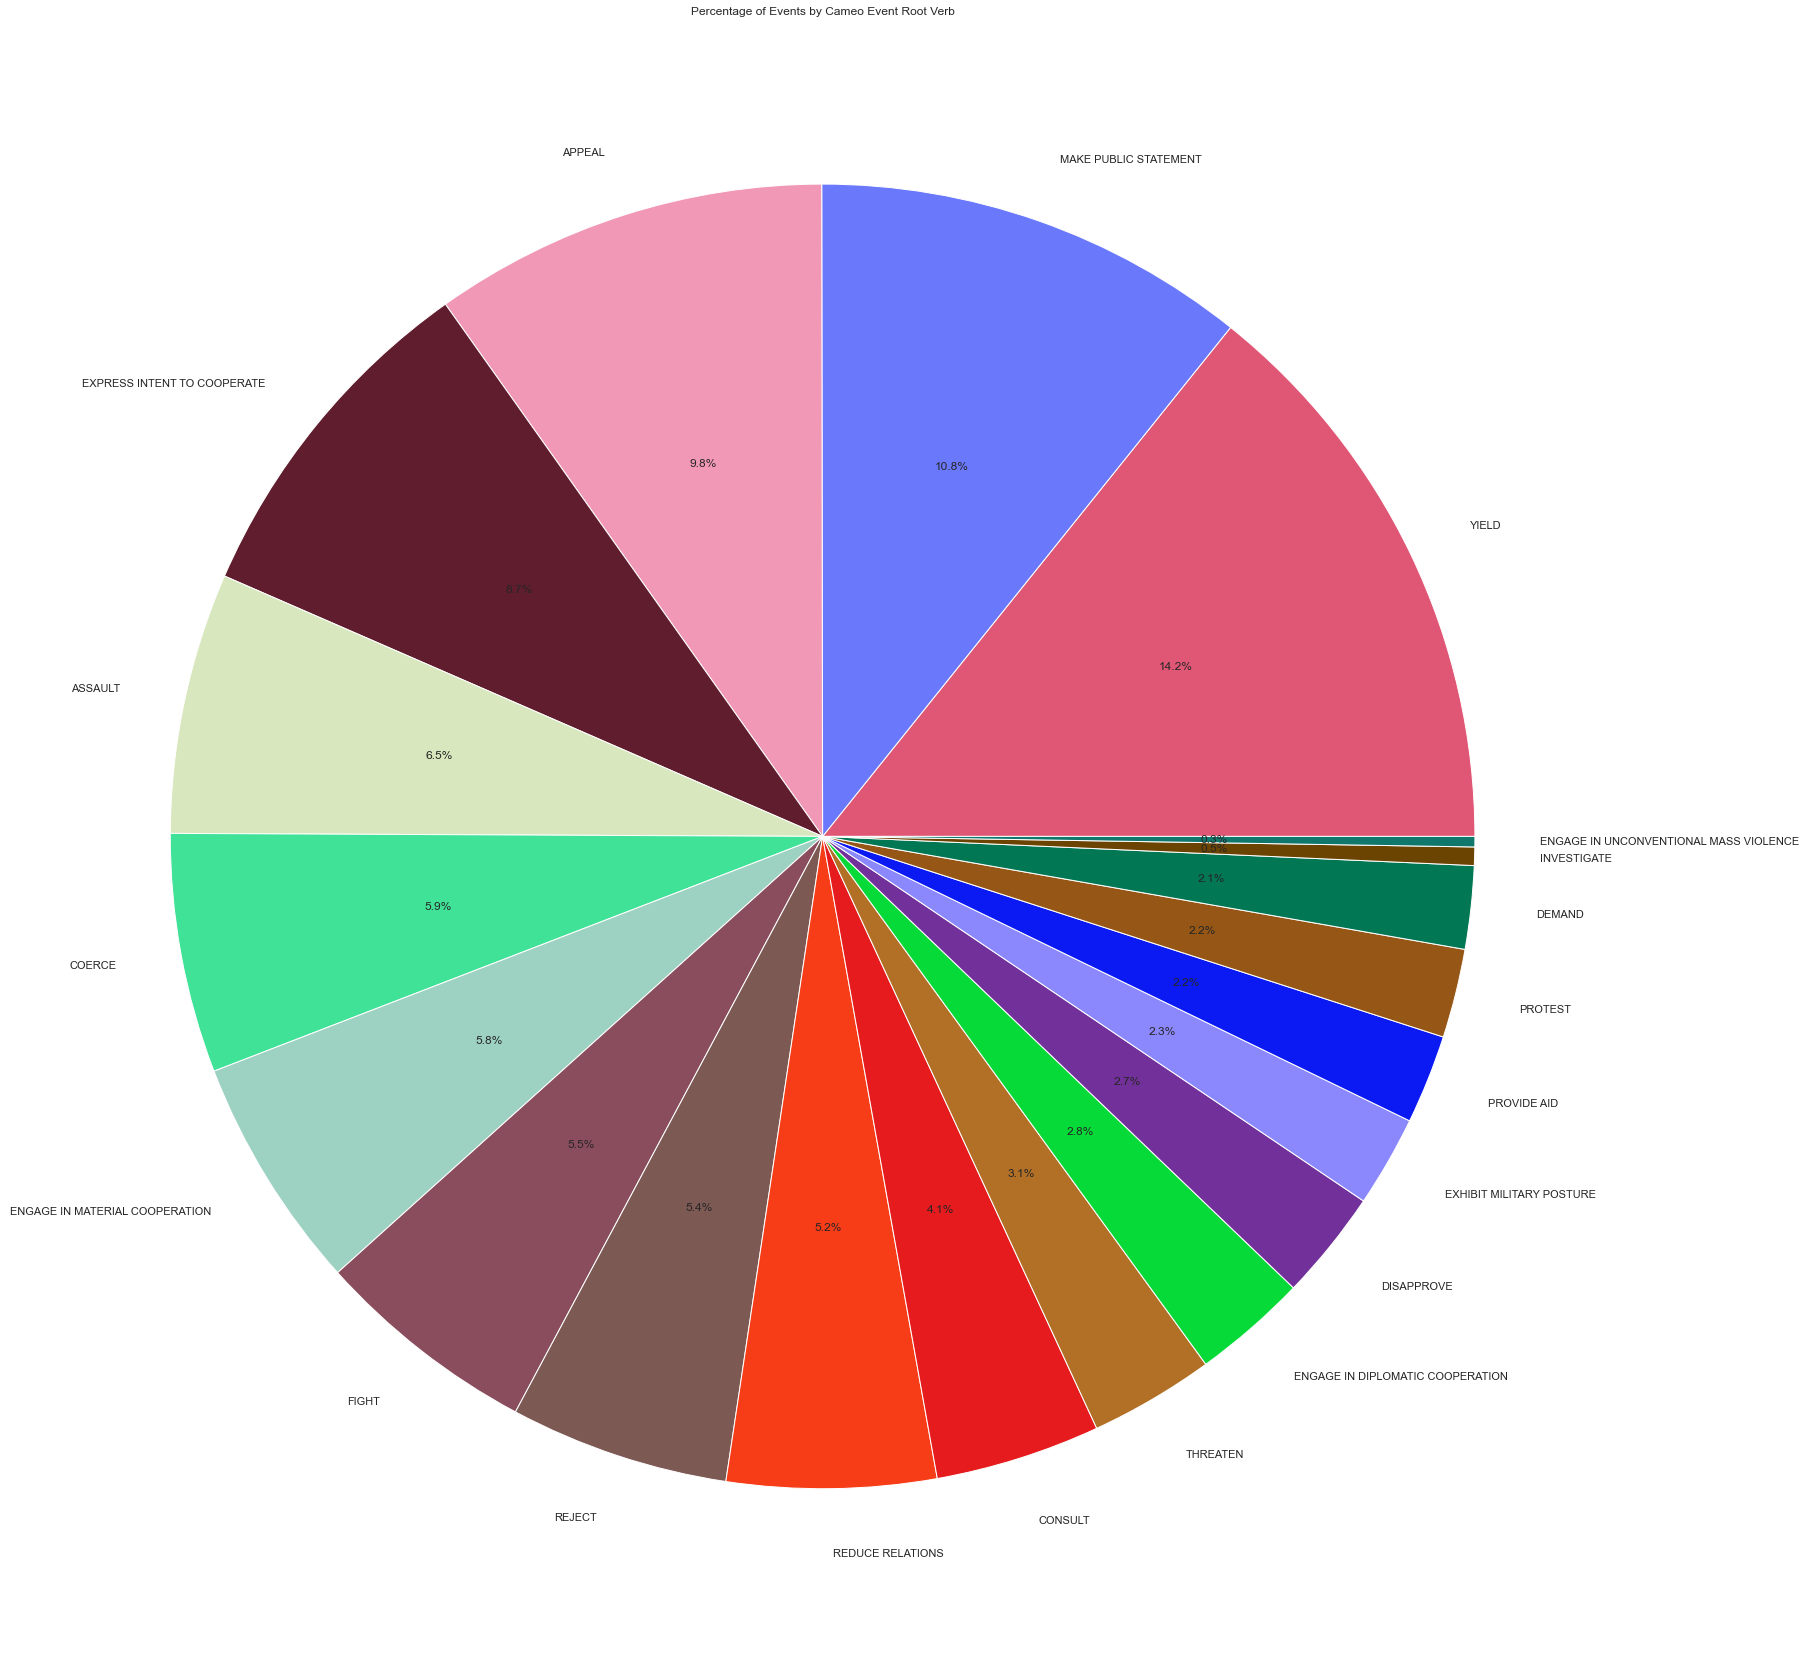

In [16]:
plot_piechart(cameoaction, 'EventRootCodeString', 'Cameo Event Root Verb', 'cameo_verb_percentages')

Observations: This exploration is briefly placed on hold until after the meeting with the Data Engineers to establish the most efficient pipeline to import GDELT's data (02 March 2021)

### Question 3: What is the Count of EventRootCodes by QuadClass? (ie. does is match the documentation?)

In [17]:
quadclass_events = cleaned_merged_df[['GLOBALEVENTID','QuadClass','QuadClassString','EventRootCodeString']].groupby(['QuadClass','QuadClassString','EventRootCodeString']).count()
print(quadclass_events.shape)
quadclass_events

(20, 1)


GLOBALEVENTID
QuadClass QuadClassString      EventRootCodeString                                  
1         Verbal Cooperation   APPEAL                                          42865
                               CONSULT                                         17904
                               ENGAGE IN DIPLOMATIC COOPERATION                12438
                               EXPRESS INTENT TO COOPERATE                     37881
                               MAKE PUBLIC STATEMENT                           47175
2         Material Cooperation ENGAGE IN MATERIAL COOPERATION                  25387
                               INVESTIGATE                                      1991
                               PROVIDE AID                                      9659
                               YIELD                                           62363
3         Verbal Conflict      DEMAND                                           9017
                               DISAPPROVE                                      11932
                               PROTEST                                          9642
                               REJECT                                          23781
                               THREATEN                                        13531
4         Material Conflict    ASSAULT                                         28282
                               COERCE                                          25973
                               ENGAGE IN UNCONVENTIONAL MASS VIOLENCE           1128
                               EXHIBIT MILITARY POSTURE                         9886
                               FIGHT                                           24249
                               REDUCE RELATIONS                                22692